# Проект для «Викишоп»

## Подготовка

#### Обзор данных

In [1]:
pip install wordcloud==1.8.2.2

     |████████████████████████████████| 458 kB 571 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
#!pip install -U pip setuptools wheel
#!pip install -U spacy
#python -m spacy download en_core_web_sm

In [3]:
#!python -m spacy download en_core_web_sm

In [4]:
import pandas as pd
import nltk
import os
import re
import lightgbm as lgb
import spacy
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from wordcloud import WordCloud

In [5]:
random.seed(42)

In [6]:
tqdm.pandas()

In [7]:
local_path = 'C:\\Users\\Aritanos\\Project12\\toxic_comments.csv'
server_path = '/datasets/toxic_comments.csv'
if os.path.exists(local_path):
    data = pd.read_csv(local_path)
else:
    data = pd.read_csv(server_path)

In [8]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [10]:
data.toxic.unique()

array([0, 1])

Пропусков в данных нет, типы данных верные, toxic имеет бинарные значения. Колонка 'Unnamed' дублирует индекс и не несёт полезной для нашей здачи информации, можно её удалить

In [11]:
data = data.drop('Unnamed: 0', axis=1)

Разделим данные на features и target:

In [12]:
features = data.text
target = data.toxic

#### Лемматизация

Сделаем лемматизацию текста в датасете.

In [13]:
spacy_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

In [14]:
corpus = features#[:10000]
target = target#[:10000]

In [15]:
def lemmatize(text):
    parsed_text = spacy_model(text.lower())
    return " ".join([token.lemma_ for token in parsed_text])

In [16]:
def clear_text(text):
    split = re.sub(r'[^A-zA-Z]', ' ', text).split()
    return ' '.join(split)

Загрузим стоп-слова:

In [17]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
stopwords = set(nltk_stopwords.words('english'))

In [19]:
%%time
corpus_lemmatized = corpus.progress_apply(lambda x: lemmatize(clear_text(x)))
corpus_lemmatized

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 15min 10s, sys: 6.63 s, total: 15min 16s
Wall time: 15min 40s


0         explanation why the edit make under my usernam...
1         d aww he match this background colour I m seem...
2         hey man I m really not try to edit war it s ju...
3         more I can t make any real suggestion on impro...
4         you sir be my hero any chance you remember wha...
                                ...                        
159287    and for the second time of ask when your view ...
159288    you should be ashamed of yourself that be a ho...
159289    spitzer umm there s no actual article for pros...
159290    and it look like it be actually you who put on...
159291    and I really don t think you understand I come...
Name: text, Length: 159292, dtype: object

#### Wordcloud

Создадим облако слов для всего объёма текстов:

In [20]:
cloud = WordCloud(stopwords=stopwords).generate(" ".join(corpus for corpus in corpus_lemmatized))

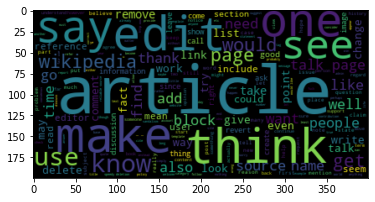

In [21]:
plt.imshow(cloud, interpolation='bilinear')

Самые часто встречающиеся слова: article, edit, make и think.

#### Разделение данных

Разделим данные на train и test:

In [89]:
features_train, features_test, target_train, target_test = train_test_split(corpus_lemmatized, target, test_size=0.25, random_state = 12345, stratify = target)

#### Борьба с дисбалансом

In [81]:
#target_train[target_train == 1].count()/target_train[target_train==0].count()

In [82]:
#features_train, target_train = upsample(features_train, target_train, 9)

In [83]:
#target_train[target_train == 1].count()/target_train[target_train==0].count()

#### Векторизация

Векторизируем текст:

In [84]:
#tf_idf_vec = TfidfVectorizer(stop_words=stopwords)

In [52]:
#%%time
#tf_idf_train = tf_idf_vec.fit_transform(features_train)
#tf_idf_test = tf_idf_vec.transform(features_test)

#### Вывод

Изучены данные. Из датасета исключена колонка 'Unnamed: 0', проведена лемматизация и векторизация данных, а также борьба с дисбалансом с помощью Upsampling.

## Обучение

Для обучения воспользуемся несколькими моделями.

#### LogisticRegression

In [94]:
params={'vect__ngram_range':[(1, 1), (3,3)]}
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords)),
    ('model', LogisticRegression(max_iter=1000))
])

In [95]:
%%time
grid = GridSearchCV(pipeline, cv=3, param_grid=params, scoring='f1')
grid.fit(features_train, target_train)
lr_best_model = grid.best_estimator_
lr_best_score = grid.best_score_
lr_best_params = grid.best_params_

CPU times: user 4min 13s, sys: 2min 46s, total: 6min 59s
Wall time: 7min


In [96]:
lr_best_model

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model', LogisticRegression(max_iter=1000))])

Скор регрессии на кросс-валидации:

In [97]:
lr_best_score

0.723916115390126

#### Random Forest

In [98]:
params={
    'vect__ngram_range':[(1, 1), (3,3)],
    'model__max_depth':[25, 45],
    'model__n_estimators':[50, 100]}

In [99]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords)),
    ('model', RandomForestClassifier(random_state=12345))
])

In [100]:
%%time
grid = GridSearchCV(pipeline, cv=3, param_grid=params, scoring='f1')
grid.fit(features_train, target_train)

CPU times: user 7min 16s, sys: 5.95 s, total: 7min 22s
Wall time: 7min 23s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
          

In [101]:
rf_best_model = grid.best_estimator_
rf_best_score = grid.best_score_
rf_best_params = grid.best_params_

Скор леса на кросс-валидации:

In [102]:
rf_best_score

0.07034844507980414

#### Gradient Boosting

In [103]:
params = {
    'vect__ngram_range':[(1, 1), (3,3)],
    'model__metric':['f1'], 
    'model__num_iterations':[200], 
    'model__boosting':['gbdt'], 
    'model__max_depth':[25],
    'model__num_leaves':[45], 
    'model__learning_rate':[0.2],
         }

In [104]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords)),
    ('model', lgb.LGBMClassifier(objective='binary', metric='f1', random_state=12345))
])

In [105]:
%%time
grid = GridSearchCV(pipeline, cv=3, param_grid=params, scoring='f1')
grid.fit(features_train, target_train)
gb_best_model = grid.best_estimator_
gb_best_score = grid.best_score_
gb_best_params = grid.best_params_

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
CPU times: user 19min 49s, sys: 0 ns, total: 19min 49s
Wall time: 19min 57s


Скор бустинга на кросс-валидации:

In [106]:
gb_best_score

0.7742354202099303

#### Лучшая модель на валидации

На валидации лучшая модель - LGBMClassifier с f1-метрикой 0.774:

In [107]:
best_model = gb_best_model
best_model

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 LGBMClassifier(boosting='gbdt', learning_rate=0.2,
                                max_depth=25, metric='f1', num_iterations=200,
                                num_leaves=45, objective='binary',
                                random_state=12345))])

In [108]:
best_params = gb_best_params

#### Тестирование модели

Проверим лучшую модель по кросс-валидации на тестовых данных:

In [109]:
best_model.fit(features_train, target_train)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 LGBMClassifier(boosting='gbdt', learning_rate=0.2,
                                max_depth=25, metric='f1', num_iterations=200,
                                num_leaves=45, objective='binary',
                                random_state=12345))])

In [110]:
f1_score(target_test, best_model.predict(features_test))

0.7788394959146931

In [111]:
best_params

{'model__boosting': 'gbdt',
 'model__learning_rate': 0.2,
 'model__max_depth': 25,
 'model__metric': 'f1',
 'model__num_iterations': 200,
 'model__num_leaves': 45,
 'vect__ngram_range': (1, 1)}

In [112]:
best_model

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 LGBMClassifier(boosting='gbdt', learning_rate=0.2,
                                max_depth=25, metric='f1', num_iterations=200,
                                num_leaves=45, objective='binary',
                                random_state=12345))])

#### Вывод

Лучшая модель - LGBMClassifier с параметрами (boosting='gbdt', learning_rate=0.2,
                                max_depth=25, metric='f1', num_iterations=200,
                                num_leaves=45, objective='binary',
                                random_state=12345). Лучшее количество n-gram: (1,1). Метрика f1 на тестовых данных - 0.779.

## Выводы

В ходе проекта были изучены данные токсичных комментариев. Проведена лемматизация текстов и их векторизация с исключением стоп-слов, а также визуализировано облако наиболее частых слов.

Были обучены три модели: LogisticRegression, RandomForestClassifier и LGBMClassifier. Хуже всего показал себя RandomForest, его метрика значительно уступает остальным. Метрика f1 логистической регрессии не достигает порога в 0.75, а LGBM бустинг с параметрами (boosting='gbdt', learning_rate=0.2, max_depth=25, metric='f1', num_iterations=200, num_leaves=45, objective='binary', random_state=12345) и n-gram= (1,1) преодолел порог метрики со значением 0.779 на тестовых данных. Лучшая модель - LGBMClassifier.